In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load PRISM data
luna = pd.read_csv("Puerto de luna.csv")

# Parse daily date
luna["Date"] = pd.to_datetime(luna["Date"])

# Convert precipitation inches → mm
luna["Precip_mm"] = luna["ppt (inches)"] * 25.4

# Extract year and month
luna["Year"] = luna["Date"].dt.year
luna["Month"] = luna["Date"].dt.month

luna.head()


,Date,ppt (inches),tmean (degrees F),Precip_mm,Year,Month
0,1985-01-01,0.0,32.2,0.0,1985,1
1,1985-01-02,0.0,31.8,0.0,1985,1
2,1985-01-03,0.0,33.1,0.0,1985,1
3,1985-01-04,0.0,32.4,0.0,1985,1
4,1985-01-05,0.0,29.8,0.0,1985,1


In [2]:
monthly_luna = (
    luna.groupby(["Year", "Month"])["Precip_mm"]
    .sum()
    .reset_index()
)

monthly_luna["Date"] = pd.to_datetime(
    monthly_luna["Year"].astype(str) + "-" +
    monthly_luna["Month"].astype(str) + "-01"
)


In [3]:
summer_luna = monthly_luna[
    monthly_luna["Month"].isin([6,7,8,9])
].copy()


In [4]:
# 3-month rolling precipitation
summer_luna["PPT_3"] = summer_luna["Precip_mm"].rolling(3).sum()

# Summer baseline
mean_summer = summer_luna["PPT_3"].mean()
std_summer  = summer_luna["PPT_3"].std()

# Historical SPI (reference)
summer_luna["SPI_3"] = (summer_luna["PPT_3"] - mean_summer) / std_summer


In [5]:
baseline_year = 2020
n_years = 100
summer_months = 4
n_points = n_years * summer_months

# Example drying trend: 10% reduction over 100 years
trend = np.linspace(1.0, 0.90, n_points)

synthetic_precip = np.random.choice(
    summer_luna["Precip_mm"].dropna(),
    size=n_points,
    replace=True
) * trend


In [6]:
future_spi = (synthetic_precip - mean_summer) / std_summer


In [7]:
future_dates = []
year = baseline_year + 1

for _ in range(n_years):
    for m in [6,7,8,9]:
        future_dates.append(pd.Timestamp(year=year, month=m, day=1))
    year += 1

future_luna = pd.DataFrame({
    "Date": future_dates,
    "SPI": future_spi
})

future_luna["Year"] = future_luna["Date"].dt.year


In [8]:
near_luna = future_luna[
    future_luna["Year"] <= baseline_year + 50
]

middle_luna = future_luna[
    (future_luna["Year"] > baseline_year + 50) &
    (future_luna["Year"] <= baseline_year + 70)
]

far_luna = future_luna[
    (future_luna["Year"] > baseline_year + 70) &
    (future_luna["Year"] <= baseline_year + 100)
]


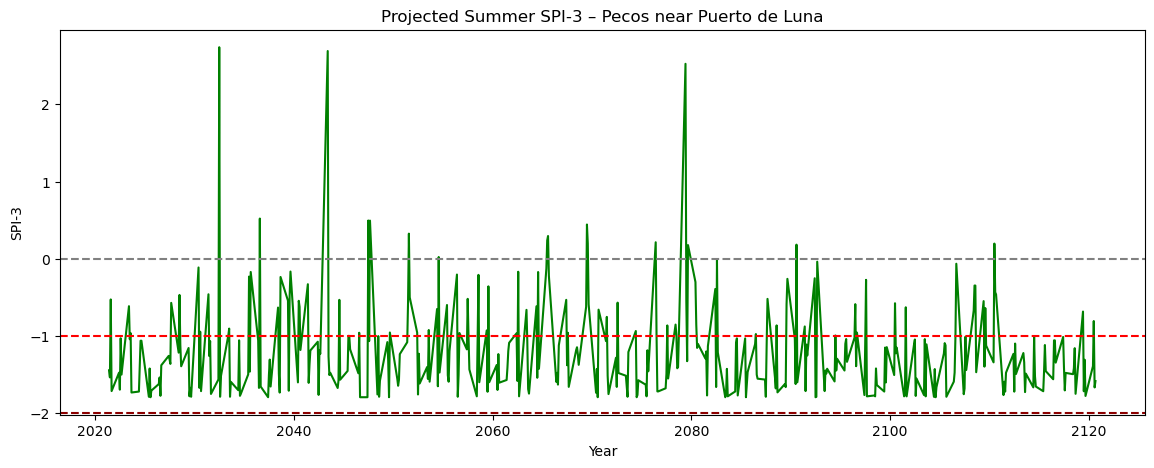

In [10]:
plt.figure(figsize=(14,5))
plt.plot(future_luna["Date"], future_luna["SPI"], color="green")
plt.axhline(0, color="gray", linestyle="--")
plt.axhline(-1, color="red", linestyle="--")
plt.axhline(-2, color="darkred", linestyle="--")

plt.title("Projected Summer SPI-3 – Pecos near Puerto de Luna")
plt.ylabel("SPI-3")
plt.xlabel("Year")
plt.show()


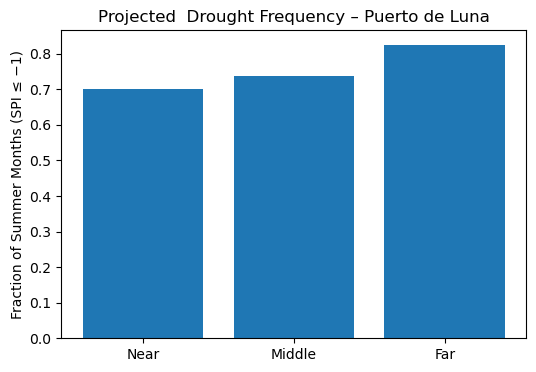

In [11]:
def drought_fraction(df):
    return (df["SPI"] <= -1).sum() / len(df)

freqs = {
    "Near": drought_fraction(near_luna),
    "Middle": drought_fraction(middle_luna),
    "Far": drought_fraction(far_luna)
}

plt.figure(figsize=(6,4))
plt.bar(freqs.keys(), freqs.values())
plt.ylabel("Fraction of Summer Months (SPI ≤ −1)")
plt.title("Projected  Drought Frequency – Puerto de Luna")
plt.show()


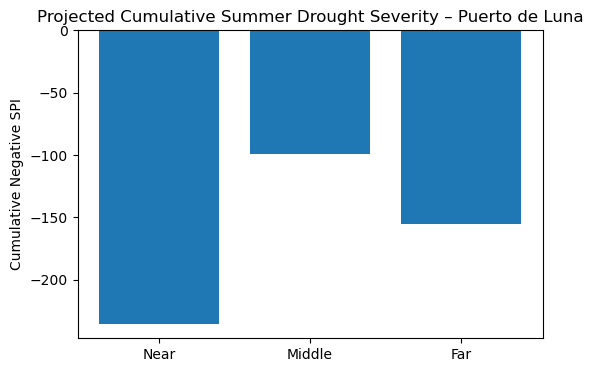

In [12]:
def cumulative_severity(df):
    return df[df["SPI"] < 0]["SPI"].sum()

sev = {
    "Near": cumulative_severity(near_luna),
    "Middle": cumulative_severity(middle_luna),
    "Far": cumulative_severity(far_luna)
}

plt.figure(figsize=(6,4))
plt.bar(sev.keys(), sev.values())
plt.ylabel("Cumulative Negative SPI")
plt.title("Projected Cumulative Summer Drought Severity – Puerto de Luna")
plt.show()
